In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from rdkit import Chem
from rdkit.Chem import Draw

# Define SMILES character set
SMILES_CHARS = ['.', 'c', 'n', 'o', 'C', 'N', 'F', 'K', '=', 'O', 'H', '%', '0', ']', '[', 'Na', 'Li', 'Ca', 'Cd',
                'Te', '(', ')', '1', '\\', '/', '2', '#', 'Cl', 'B', 's', 'S', 'Se', 'Ge', 'Br', 'Sn', 'Zn', 'Si',
                'se', 'I', 'Pb', '3', '4', '5', '6', '7', '8', '+', '-', '9', 'P', '*']
stoi = {s: i for i, s in enumerate(SMILES_CHARS)}
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

# Set data file paths
DATA_FILE = r"/kaggle/input/data-of-tg/tg_raw.csv"
OUTPUT_FILE = r"/kaggle/input/data-of-tg/generated_smiles.txt"

# Model hyperparameters
BLOCK_SIZE = 100
BATCH_SIZE = 64
EMBED_SIZE = 128
N_HEAD = 4
N_LAYER = 4
DROP_RATE = 0.1
LR = 3e-4
N_EPOCHS = 10
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
data = pd.read_csv(DATA_FILE)
text = data['SMILES']

def encode_smiles(sm):
    return [stoi[s] for s in sm if s in stoi]

def decode_smiles(idx):
    return ''.join([itos[i] for i in idx])

# Tokenize SMILES strings
data_encoded = [encode_smiles(sm) for sm in text]

# Pad or truncate sequences to BLOCK_SIZE
for i, sm in enumerate(data_encoded):
    if len(sm) < BLOCK_SIZE:
        data_encoded[i] = sm + [0] * (BLOCK_SIZE - len(sm))
    else:
        data_encoded[i] = sm[:BLOCK_SIZE]

data_tensor = torch.tensor(data_encoded, dtype=torch.long)

# Split data
train_size = int(0.8 * len(data_tensor))
val_size = len(data_tensor) - train_size
train_data, val_data = torch.utils.data.random_split(data_tensor, [train_size, val_size])

# Datasets and Dataloader
class SmileDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x = self.data[idx][:-1]
        y = self.data[idx][1:]
        return x, y

train_dataset = SmileDataset(train_data)
val_dataset = SmileDataset(val_data)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Transformer Model
class SmileTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size, block_size, n_head, n_layer, drop_rate):
        super(SmileTransformer, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = nn.Embedding(block_size, embed_size)
        encoder_layers = nn.TransformerEncoderLayer(embed_size, n_head, embed_size * 4, drop_rate)
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers=n_layer)
        self.lm_head = nn.Linear(embed_size, vocab_size)
        self.block_size = block_size

    def forward(self, x):
        B, T = x.size()
        pos = torch.arange(0, T, dtype=torch.long, device=x.device).unsqueeze(0)
        x = self.token_embedding(x) + self.position_embedding(pos)
        x = self.transformer(x.permute(1, 0, 2))
        logits = self.lm_head(x.permute(1, 0, 2))
        return logits

model = SmileTransformer(vocab_size, EMBED_SIZE, BLOCK_SIZE, N_HEAD, N_LAYER, DROP_RATE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training loop
for epoch in range(N_EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_dataloader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{N_EPOCHS}, Loss: {total_loss / len(train_dataloader):.4f}")

# Save model
torch.save(model.state_dict(), "smiles_model.pth")

# Generate new SMILES
model.eval()
with torch.no_grad():
    start_idx = random.randint(0, len(train_data) - 1)
    start_sequence = train_data[start_idx][:BLOCK_SIZE].unsqueeze(0).to(device)
    generated_smiles = [start_sequence]
    for _ in range(BLOCK_SIZE):
        logits = model(start_sequence)
        probs = F.softmax(logits[:, -1, :], dim=-1)
        ix = torch.multinomial(probs, num_samples=1).item()
        start_sequence = torch.cat([start_sequence, torch.tensor([[ix]], device=device)], dim=1)
        if ix == 0:
            break
    decoded_smiles = decode_smiles(start_sequence.squeeze().tolist())
    print(f"Generated SMILES: {decoded_smiles}")

# Save results
#with open(OUTPUT_FILE, "w") as f:
#    f.write(decoded_smiles + "\n")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10, Loss: 1.3411
Epoch 2/10, Loss: 0.9125
Epoch 3/10, Loss: 0.7003
Epoch 4/10, Loss: 0.3610
Epoch 5/10, Loss: 0.1695
Epoch 6/10, Loss: 0.0940
Epoch 7/10, Loss: 0.0605
Epoch 8/10, Loss: 0.0416
Epoch 9/10, Loss: 0.0310
Epoch 10/10, Loss: 0.0239
Generated SMILES: *C(=O)Nc1cccc(NC(=O)c2ccc3c(c2)C(=O)N(c2cc(-c4nc5ccccc5o4)cc(N4C(=O)c5ccc(*)cc5C4=O)c2)C3=O)n1.......


In [5]:
print(len(decoded_smiles)

*OP(=O)(Oc1ccc(B)cc1)OC(CC)COc1ccc(S(=O)(=O)c2ccc(OCC(*)CC)cc2)cc1...................................


In [1]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 56.4 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from rdkit import Chem
from rdkit.Chem import Draw

# Define SMILES character set
SMILES_CHARS = ['.', 'c', 'n', 'o', 'C', 'N', 'F', 'K', '=', 'O', 'H', '%', '0', ']', '[', 'Na', 'Li', 'Ca', 'Cd',
                'Te', '(', ')', '1', '\\', '/', '2', '#', 'Cl', 'B', 's', 'S', 'Se', 'Ge', 'Br', 'Sn', 'Zn', 'Si',
                'se', 'I', 'Pb', '3', '4', '5', '6', '7', '8', '+', '-', '9', 'P', '*']
stoi = {s: i for i, s in enumerate(SMILES_CHARS)}
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

# Set data file paths
DATA_FILE = r"/kaggle/input/data-of-tg/tg_raw.csv"
OUTPUT_FILE = r"/kaggle/working/generated_smiles.txt"


# Model hyperparameters
BLOCK_SIZE = 100
BATCH_SIZE = 64
EMBED_SIZE = 128
N_HEAD = 4
N_LAYER = 4
DROP_RATE = 0.1
LR = 3e-4
N_EPOCHS = 10
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
data = pd.read_csv(DATA_FILE)
text = data['SMILES']

# Encode SMILES to integer sequences
def encode_smiles(sm):
    return [stoi[s] for s in sm if s in stoi]

def decode_smiles(idx):
    return ''.join([itos[i] for i in idx if i in itos and i != 0])  # Skip padding

# Tokenize and pad/truncate SMILES
data_encoded = [encode_smiles(sm) for sm in text]

for i, sm in enumerate(data_encoded):
    if len(sm) < BLOCK_SIZE:
        data_encoded[i] = sm + [0] * (BLOCK_SIZE - len(sm))  # Pad
    else:
        data_encoded[i] = sm[:BLOCK_SIZE]  # Truncate

data_tensor = torch.tensor(data_encoded, dtype=torch.long)

# Split data into train and validation sets
train_size = int(0.8 * len(data_tensor))
val_size = len(data_tensor) - train_size
train_data, val_data = torch.utils.data.random_split(data_tensor, [train_size, val_size])

# Define dataset class
class SmileDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x = self.data[idx][:-1]
        y = self.data[idx][1:]
        return x, y

# Create data loaders
train_dataset = SmileDataset(train_data)
val_dataset = SmileDataset(val_data)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Define Transformer model
class SmileTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size, block_size, n_head, n_layer, drop_rate):
        super(SmileTransformer, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = nn.Embedding(block_size, embed_size)
        encoder_layers = nn.TransformerEncoderLayer(embed_size, n_head, embed_size * 4, drop_rate)
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers=n_layer)
        self.lm_head = nn.Linear(embed_size, vocab_size)
        self.block_size = block_size

    def forward(self, x):
        B, T = x.size()
        pos = torch.arange(0, T, dtype=torch.long, device=x.device).unsqueeze(0).expand(B, -1)
        x = self.token_embedding(x) + self.position_embedding(pos)
        x = self.transformer(x.permute(1, 0, 2))  # [T, B, C]
        logits = self.lm_head(x.permute(1, 0, 2))  # [B, T, vocab_size]
        return logits

# Initialize model and optimizer
model = SmileTransformer(vocab_size, EMBED_SIZE, BLOCK_SIZE, N_HEAD, N_LAYER, DROP_RATE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training loop
for epoch in range(N_EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_dataloader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{N_EPOCHS}, Loss: {total_loss / len(train_dataloader):.4f}")

# Save trained model
torch.save(model.state_dict(), "smiles_model.pth")

# Generate new SMILES
model.eval()
with torch.no_grad():
    start_idx = random.randint(0, len(train_data) - 1)
    start_sequence = train_data[start_idx][:BLOCK_SIZE].unsqueeze(0).to(device)
    generated_smiles = start_sequence.tolist()[0]
    
    for _ in range(BLOCK_SIZE):
        logits = model(start_sequence)
        probs = F.softmax(logits[:, -1, :], dim=-1)
        ix = torch.multinomial(probs, num_samples=1).item()
        
        # Stop if the padding token (0) or invalid index is generated
        if ix == 0 or ix >= vocab_size:
            break
        
        generated_smiles.append(ix)
        
        # Maintain block size
        if len(generated_smiles) > BLOCK_SIZE:
            generated_smiles = generated_smiles[1:]

        start_sequence = torch.tensor([generated_smiles[-BLOCK_SIZE:]], device=device)
    
    decoded_smiles = decode_smiles(generated_smiles)
    print(f"Generated SMILES: {decoded_smiles}")

# Save generated SMILES to file
with open(OUTPUT_FILE, "w") as f:
    f.write(decoded_smiles + "\n")


In [ ]:
import os

# List all files in /kaggle/working/
print("Files in /kaggle/working/:")
print(os.listdir("/kaggle/working/"))


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import FileLink, display

# Define SMILES character set
SMILES_CHARS = ['.', 'c', 'n', 'o', 'C', 'N', 'F', 'K', '=', 'O', 'H', '%', '0', ']', '[', 'Na', 'Li', 'Ca', 'Cd',
                'Te', '(', ')', '1', '\\', '/', '2', '#', 'Cl', 'B', 's', 'S', 'Se', 'Ge', 'Br', 'Sn', 'Zn', 'Si',
                'se', 'I', 'Pb', '3', '4', '5', '6', '7', '8', '+', '-', '9', 'P', '*']
stoi = {s: i for i, s in enumerate(SMILES_CHARS)}
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

# Set data file paths
DATA_FILE = r"/kaggle/input/data-of-tg/tg_raw.csv"
OUTPUT_FILE = r"/kaggle/working/generated_smiles.txt"

# Model hyperparameters
BLOCK_SIZE = 100
BATCH_SIZE = 64
EMBED_SIZE = 128
N_HEAD = 4
N_LAYER = 4
DROP_RATE = 0.1
LR = 3e-4
N_EPOCHS = 10
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
data = pd.read_csv(DATA_FILE)
text = data['SMILES']

# Encode SMILES to integer sequences
def encode_smiles(sm):
    return [stoi[s] for s in sm if s in stoi]

def decode_smiles(idx):
    return ''.join([itos[i] for i in idx if i in itos and i != 0])  # Skip padding

# Tokenize and pad/truncate SMILES
data_encoded = [encode_smiles(sm) for sm in text]

for i, sm in enumerate(data_encoded):
    if len(sm) < BLOCK_SIZE:
        data_encoded[i] = sm + [0] * (BLOCK_SIZE - len(sm))  # Pad
    else:
        data_encoded[i] = sm[:BLOCK_SIZE]  # Truncate

data_tensor = torch.tensor(data_encoded, dtype=torch.long)

# Split data into train and validation sets
train_size = int(0.8 * len(data_tensor))
val_size = len(data_tensor) - train_size
train_data, val_data = torch.utils.data.random_split(data_tensor, [train_size, val_size])

# Define dataset class
class SmileDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x = self.data[idx][:-1]
        y = self.data[idx][1:]
        return x, y

# Create data loaders
train_dataset = SmileDataset(train_data)
val_dataset = SmileDataset(val_data)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Define Transformer model
class SmileTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size, block_size, n_head, n_layer, drop_rate):
        super(SmileTransformer, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = nn.Embedding(block_size, embed_size)
        encoder_layers = nn.TransformerEncoderLayer(embed_size, n_head, embed_size * 4, drop_rate)
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers=n_layer)
        self.lm_head = nn.Linear(embed_size, vocab_size)
        self.block_size = block_size

    def forward(self, x):
        B, T = x.size()
        pos = torch.arange(0, T, dtype=torch.long, device=x.device).unsqueeze(0).expand(B, -1)
        x = self.token_embedding(x) + self.position_embedding(pos)
        x = self.transformer(x.permute(1, 0, 2))  # [T, B, C]
        logits = self.lm_head(x.permute(1, 0, 2))  # [B, T, vocab_size]
        return logits

# Initialize model and optimizer
model = SmileTransformer(vocab_size, EMBED_SIZE, BLOCK_SIZE, N_HEAD, N_LAYER, DROP_RATE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training loop
for epoch in range(N_EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_dataloader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{N_EPOCHS}, Loss: {total_loss / len(train_dataloader):.4f}")

# Save trained model
torch.save(model.state_dict(), "smiles_model.pth")

# Generate multiple SMILES strings
model.eval()
generated_smiles_list = []
n_generated = 100  # Generate 100 samples

with torch.no_grad():
    for _ in range(n_generated):
        start_idx = random.randint(0, len(train_data) - 1)
        start_sequence = train_data[start_idx][:BLOCK_SIZE].unsqueeze(0).to(device)
        generated_smiles = start_sequence.tolist()[0]
        
        for _ in range(BLOCK_SIZE):
            logits = model(start_sequence)
            probs = F.softmax(logits[:, -1, :], dim=-1)
            ix = torch.multinomial(probs, num_samples=1).item()
            
            # Stop if the padding token (0) or invalid index is generated
            if ix == 0 or ix >= vocab_size:
                break
            
            generated_smiles.append(ix)
            
            # Maintain block size
            if len(generated_smiles) > BLOCK_SIZE:
                generated_smiles = generated_smiles[1:]

            start_sequence = torch.tensor([generated_smiles[-BLOCK_SIZE:]], device=device)
        
        decoded_smiles = decode_smiles(generated_smiles)
        generated_smiles_list.append(decoded_smiles)

# Save generated SMILES to file
with open(OUTPUT_FILE, "w") as f:
    for smiles in generated_smiles_list:
        f.write(smiles + "\n")

print(f"{len(generated_smiles_list)} SMILES generated and saved to {OUTPUT_FILE}")


valid_smiles_count = 0
valid_smiles_strings=[]
for sm in generated_smiles_list:
    mol = Chem.MolFromSmiles(sm)
    if mol:
        valid_smiles_strings.append(sm)
        valid_smiles_count += 1

print(f" Valid molecules generated: {valid_smiles_count}/{n_generated}")

#  Create download link for the generated file
print("Click below to download the generated SMILES file:")
display(FileLink(OUTPUT_FILE))


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10, Loss: 1.3411
Epoch 2/10, Loss: 0.9125
Epoch 3/10, Loss: 0.7003
Epoch 4/10, Loss: 0.3610
Epoch 5/10, Loss: 0.1695
Epoch 6/10, Loss: 0.0940
Epoch 7/10, Loss: 0.0605
Epoch 8/10, Loss: 0.0416
Epoch 9/10, Loss: 0.0310
Epoch 10/10, Loss: 0.0239
100 SMILES generated and saved to /kaggle/working/generated_smiles.txt
✅ Valid molecules generated: 86/100
⬇️ Click below to download the generated SMILES file:


[11:43:09] SMILES Parse Error: syntax error while parsing: 0ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc
[11:43:09] SMILES Parse Error: check for mistakes around position 1:
[11:43:09] 0cccccccccccccccccccccccccccccccccccccccc
[11:43:09] ^
[11:43:09] SMILES Parse Error: Failed parsing SMILES '0ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc' for input: '0ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc'
[11:43:09] SMILES Parse Error: unclosed ring for input: 'cc2ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc'
[11:43:09] SMILES Parse Error: extra close parentheses while parsing: O)O)O)O)P(F)O)O)O)O)O)O)O)O)O)O)O)O)O)O)O)O)O)O)O)O)O)O)O)O)O)O)OO)OO)O)O)OOO)OOO)O)OOOCdCaOOOO)OOO)OO
[11:43:09] SMILES Parse Error: check for mistakes around position 2:
[11:43:09] O)O)O)O)P(F)O)O)O)O)O)O

/kaggle/working/generated_smiles.txt

[11:43:16] DEPRECATION WARNING: please use MorganGenerator
[11:43:16] DEPRECATION WARNING: please use MorganGenerator
[11:43:16] DEPRECATION WARNING: please use MorganGenerator
[11:43:16] DEPRECATION WARNING: please use MorganGenerator
[11:43:16] DEPRECATION WARNING: please use MorganGenerator
[11:43:16] DEPRECATION WARNING: please use MorganGenerator
[11:43:16] DEPRECATION WARNING: please use MorganGenerator
[11:43:16] DEPRECATION WARNING: please use MorganGenerator
[11:43:16] DEPRECATION WARNING: please use MorganGenerator
[11:43:16] DEPRECATION WARNING: please use MorganGenerator
[11:43:16] DEPRECATION WARNING: please use MorganGenerator
[11:43:16] DEPRECATION WARNING: please use MorganGenerator
[11:43:16] DEPRECATION WARNING: please use MorganGenerator
[11:43:16] DEPRECATION WARNING: please use MorganGenerator
[11:43:16] DEPRECATION WARNING: please use MorganGenerator
[11:43:16] DEPRECATION WARNING: please use MorganGenerator
[11:43:16] DEPRECATION WARNING: please use MorganGenerat

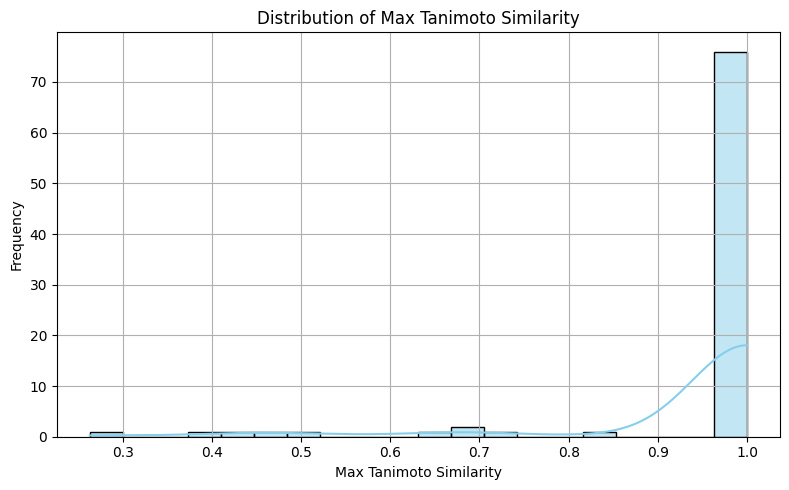

In [3]:
from rdkit import DataStructs
from rdkit.Chem import AllChem
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Get original valid molecules from the dataset
original_smiles = data['SMILES'].dropna().tolist()
original_mols = [Chem.MolFromSmiles(sm) for sm in original_smiles if Chem.MolFromSmiles(sm)]

# Precompute fingerprints for originals
original_fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=2048) for m in original_mols]

# Step 2: Calculate max Tanimoto similarity for each generated valid molecule
similarity_results = []

for sm in valid_smiles_strings:
    mol = Chem.MolFromSmiles(sm)
    if mol:
        gen_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        sims = DataStructs.BulkTanimotoSimilarity(gen_fp, original_fps)
        max_sim = max(sims)
        similarity_results.append({
            "Generated_SMILES": sm,
            "Max_Tanimoto_Similarity": max_sim
        })

# Convert to DataFrame
results_df = pd.DataFrame(similarity_results)

# Step 3: Plot similarity distribution
plt.figure(figsize=(8, 5))
sns.histplot(results_df["Max_Tanimoto_Similarity"], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Max Tanimoto Similarity")
plt.xlabel("Max Tanimoto Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
for i in generated_smiles_list:
    print(i+'\n')

CCCC(C)C(C)C

CC12CC(N1)C2(N)C#N

C1C23CCC12C=CCC3

NC(=O)C(=O)CO

OC12CC3C1OCC3C2

OC1(CC(=O)C=O)CC1

COCC(=O)C(C)C=O

C(C1CC1)C1=CC=CO1

O=CC12CC3C(O1)C3O2

CN1CC2COC(=N)C12

CC1C2CN2C11CC1O

C1C=CC2C3OC2C13

C1CC2=CCOCC2=C1

CCC1OCCC(=O)O1

CC(O)C(=O)N(C)C

CC1=CC(F)=NC(F)=N1

CC#CC1=CCC2CC12

O=C(C#C)C1COC1

CC1N(C)C1(CO)CO

O=CN1N=CC(C=O)=N1

CN=C1NC(=O)CC1C

O=CC1OC1(C#C)C#N

CC1(CO)COCOC1

CC1C2CCC1C(=O)O2

NCC(=O)OCCO

CC1(O)C2OC2C11CN1

CC1C2CN2CC1(C)C

C1OC2CC3OC3C2=C1

N#CC1=CN2CCC2=C1

CCC(C1CC1)C1CO1

CC(O)C1=CCC2OC12

OCC12CC1OCC2

O1N=CC2=NC=NC2=N1

NC1=CC=C(F)C=C1

O=C1OC2C3NC3C2O1

CN1C(=N)OC(O)=C1C

C1CC11C2NC2C11CN1

CCNC1=C(N)NN=N1

O=C1NC2CN3CCC123

C(C1CC1)C1=CON=N1

CCCC1(CN1C)C#C

COC12CN3CC1(C)C23

CC1N(C)C1(C)CO

CC1CN2CC12CCO

COC12C(C)N3C1CC23

COC(C#N)C1CN1

OC1CN=C2NCC12O

CCC1CC=CCC1O

CN1N=C(N=C1C)C#C

COC=NC1=NOC=C1

CCC1(CO)OC1C

CC(=O)C1=NON=C1N

COC(C)CCC=O

CC12CC3CC(O3)C1O2

CN1C=C(C)C=N1

CCCC1CCC1

C1C2NC2C2=C1ON=N2

CC(=O)OCCCC#C

N=C1NCC2CC2C1=

In [21]:
for i in valid_smiles_strings:
    print(i + '\n')

CCCC(C)C(C)C

CC12CC(N1)C2(N)C#N

C1C23CCC12C=CCC3

NC(=O)C(=O)CO

OC12CC3C1OCC3C2

OC1(CC(=O)C=O)CC1

COCC(=O)C(C)C=O

C(C1CC1)C1=CC=CO1

O=CC12CC3C(O1)C3O2

CN1CC2COC(=N)C12

CC1C2CN2C11CC1O

C1C=CC2C3OC2C13

C1CC2=CCOCC2=C1

CCC1OCCC(=O)O1

CC(O)C(=O)N(C)C

CC1=CC(F)=NC(F)=N1

CC#CC1=CCC2CC12

O=C(C#C)C1COC1

CC1N(C)C1(CO)CO

O=CN1N=CC(C=O)=N1

CN=C1NC(=O)CC1C

O=CC1OC1(C#C)C#N

CC1(CO)COCOC1

CC1C2CCC1C(=O)O2

NCC(=O)OCCO

CC1(O)C2OC2C11CN1

CC1C2CN2CC1(C)C

C1OC2CC3OC3C2=C1

N#CC1=CN2CCC2=C1

CCC(C1CC1)C1CO1

CC(O)C1=CCC2OC12

OCC12CC1OCC2

O1N=CC2=NC=NC2=N1

NC1=CC=C(F)C=C1

O=C1OC2C3NC3C2O1

CN1C(=N)OC(O)=C1C

C1CC11C2NC2C11CN1

CCNC1=C(N)NN=N1

O=C1NC2CN3CCC123

C(C1CC1)C1=CON=N1

CCCC1(CN1C)C#C

COC12CN3CC1(C)C23

CC1N(C)C1(C)CO

CC1CN2CC12CCO

COC12C(C)N3C1CC23

COC(C#N)C1CN1

OC1CN=C2NCC12O

CCC1CC=CCC1O

CN1N=C(N=C1C)C#C

COC=NC1=NOC=C1

CCC1(CO)OC1C

CC(=O)C1=NON=C1N

COC(C)CCC=O

CC12CC3CC(O3)C1O2

CN1C=C(C)C=N1

CCCC1CCC1

C1C2NC2C2=C1ON=N2

CC(=O)OCCCC#C

N=C1NCC2CC2C1=

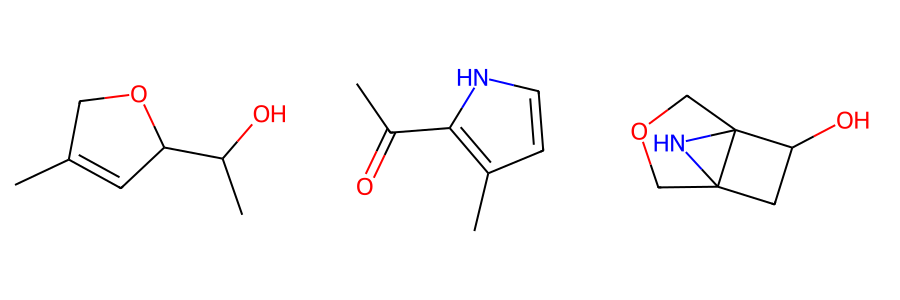

In [26]:

from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# List of SMILES strings
smiles_list = ["CC(O)C1OCC(C)=C1", "CC(=O)C1=C(C)C=CN1", "OC1CC23COCC12N3"]  

# Create RDKit molecule objects
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list if Chem.MolFromSmiles(smiles)]

# Draw and display multiple molecules in a grid
img = Draw.MolsToGridImage(molecules, molsPerRow=3, subImgSize=(300, 300))

# Display the image in Jupyter Notebook or Colab
display(img)


